# 4) Gender in the Text: Pronouns & Nearby Verbs

**Goal:** Compare relative frequency of pronouns and the verbs near them.

# Setup: Load Texts

This notebook needs **Fellowship of the Ring** and **The Return of the King** as input texts.

**How to provide the texts:**
1. Aquire books through all means necessary

2. Place two text files in the "data" folder with names:
   - `Fellowship.txt`
   - `Return.txt`

In [1]:
import re
from pathlib import Path

In [4]:
def load_texts(fellowship: str = '..\\data\\Fellowship.txt',
               twotowers: str = '..\\data\\TwoTowers.txt',
               theking: str = '..\\data\\TheKing.txt'):
    """Load Fellowship and TheKing texts from disk.

    Parameters
    ----------
    fellowship : str
        Path to Fellowship text file. Defaults to '../data/Fellowship.txt'.
    theking : str
        Path to TheKing text file. Defaults to '../data/TheKing.txt'.

    Returns
    -------
    tuple[str, str]
        (fellowship_text, theking_text).

    Raises
    ------
    FileNotFoundError
        If either file is missing.

    Extra Notes
    -----------
    - Using UTF-8 with `errors='ignore'` avoids codec exceptions on
      older Project Gutenberg dumps or inconsistent encodings.
    """
    p1, p2, p3 = Path(fellowship),Path(twotowers), Path(theking)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Fellowship.txt' at this path or update load_texts(...)."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please place 'TwoTowers.txt' at this path or update load_texts(...)."
        )
    if not p3.exists():
        raise FileNotFoundError(
            f"Missing file: {p3}\n"
            "→ Please place 'TheKing.txt' at this path or update load_texts(...)."
        )

    # Read the files (UTF-8; ignore undecodable bytes to stay robust)
    fellowship   = p1.read_text(encoding='utf-8', errors='ignore')
    twotowers = p2.read_text(encoding='utf-8', errors='ignore')
    theking = p3.read_text(encoding='utf-8', errors='ignore')
    return fellowship, twotowers, theking

def normalize(text: str, is_p1: bool = False, is_p2: bool = False, is_p3: bool = False) -> str:
    """Normalize a text for tokenization."""
    if not text:
        return ''
    
    # If it's Fellowship, skip the Foreword and Prologue
    if is_p1:
        prologue_end = text.find('Chapter 1\n\nA Long-expected Party')
        if prologue_end != -1:
            text = text[prologue_end:]
    
    # For Return of the King
    if is_p2:
        contents_end = text.find('_Chapter 1_\nThe Departure of Boromir')
        if contents_end != -1:
            text = text[contents_end:]

    if is_p3:
        contents_end = text.find('Book V\n\nChapter 1. Minas Tirith')
        if contents_end != -1:
            text = text[contents_end:]

    return text.replace('\r\n', '\n')

# Normalize for tokenization
# Load raw texts (forgiving: returns '' if a file is missing)
fellowship_raw, twotowers_raw, theking_raw = load_texts()

# Normalize for tokenization
fellowship   = normalize(fellowship_raw)
twotowers = normalize(twotowers_raw)
theking = normalize(theking_raw)

print(f"Fellowship chars: {len(fellowship):,} | Two Towers chars: {len(twotowers):,} | TheKing chars: {len(theking):,}")


Fellowship chars: 999,370 | Two Towers chars: 834,448 | TheKing chars: 709,796


### Helpers: Tokenization

In [ ]:
# This new regex finds words like "don't" but skips junk like "'s"
WORD_RE = re.compile(r"\b[A-Za-z][A-Za-z']*\b") 

def words(text: str):
    """Smarter word tokenizer (lowercased, ASCII letters + internal apostrophes)."""
    return WORD_RE.findall(text.lower())


def sentences(text: str):
    """Naive sentence splitter using punctuation boundaries."""
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

# --- Run the tokenizers ---
fellowship_words = words(fellowship)
twotowers_words = words(twotowers)
theking_words = words(theking)

fellowship_sentences = sentences(fellowship)
twotowers_sentences = sentences(twotowers)
theking_sentences = sentences(theking)

# Save total word counts for later
nF = len(fellowship_words) # Total words in Fellowship
nT = len(twotowers_words)  # Total words in Two Towers
nR = len(theking_words) # Total words in TheKing

print(f"Fellowship words: {nF:,} | Two Towers words: {nT:,} | TheKing words: {nR:,}")
print(f"Fellowship sentences: {len(fellowship_sentences):,} | Two Towers: {len(twotowers_sentences):,} | TheKing sentences: {len(theking_sentences):,}")

Fellowship words: 188,415 | Two Towers words: 153,729 | TheKing words: 136,735
Fellowship sentences: 11,229 | Two Towers: 10,619 | TheKing sentences: 7,449


### Pronoun Balance

In [13]:

from collections import Counter
def pronoun_counts(tokens):
    target = {'he','she','him','her'}
    c = Counter(w for w in tokens if w in target)
    total = sum(c.values())
    return c, total

f_c, f_tot = pronoun_counts(fellowship_words)
t_c, t_tot = pronoun_counts(twotowers_words)
k_c, k_tot = pronoun_counts(theking_words)
print("Fellowship:", dict(f_c), "total:", f_tot)
print("Two Towers:", dict(t_c), "total:", t_tot)
print("TheKing:", dict(k_c), "total:", k_tot)


Fellowship: {'he': 2988, 'him': 853, 'she': 159, 'her': 161} total: 4161
Two Towers: {'he': 2580, 'him': 781, 'she': 89, 'her': 135} total: 3585
TheKing: {'he': 2435, 'him': 682, 'she': 186, 'her': 176} total: 3479


### Verbs Near Pronouns (very naive)

In [15]:

def verb_like(word):
    # crude heuristic: words ending in common verb suffixes or base forms
    return bool(re.match(r".*(ed|ing|s)$", word)) or word in {"say","says","said","go","goes","went","come","comes","came","think","thinks","thought","see","sees","saw","know","knows","knew"}

def verbs_near_pronouns(tokens, window=2):
    verbs_for = {'he':[], 'she':[]}
    for i,w in enumerate(tokens):
        if w in ('he','she'):
            for j in range(max(0,i-window), min(len(tokens), i+window+1)):
                if j==i: continue
                if verb_like(tokens[j]):
                    verbs_for[w].append(tokens[j])
    return {k: Counter(v).most_common(20) for k,v in verbs_for.items()}

print("Fellowship:", verbs_near_pronouns(fellowship_words) )
print("TheKing:", verbs_near_pronouns(theking_words) )

Fellowship: {'he': [('said', 364), ('was', 312), ('as', 189), ('his', 147), ('is', 105), ('thought', 74), ('saw', 54), ('went', 51), ('looked', 51), ('has', 50), ('cried', 49), ('came', 49), ('knew', 42), ('turned', 35), ('this', 30), ('asked', 29), ('seemed', 28), ('called', 26), ('ring', 22), ('see', 22)], 'she': [('said', 32), ('was', 18), ('as', 11), ('looked', 5), ('seemed', 4), ('is', 4), ('turning', 4), ('lifted', 4), ('thought', 3), ('called', 3), ('passed', 3), ('turned', 3), ('answered', 3), ('came', 3), ('ring', 3), ('believed', 2), ('hoped', 2), ('departed', 2), ('guests', 2), ('laughed', 2)]}
TheKing: {'he': [('said', 282), ('was', 206), ('as', 159), ('his', 137), ('is', 101), ('saw', 62), ('s', 59), ('looked', 58), ('thought', 57), ('cried', 48), ('has', 46), ('came', 37), ('went', 34), ('come', 31), ('turned', 30), ('knew', 30), ('go', 20), ('seemed', 20), ('see', 18), ('passed', 18)], 'she': [('said', 34), ('was', 16), ('is', 13), ('answered', 12), ('as', 10), ('looked'


--- Verbs Near Pronouns Analysis ---
Graph saved to 'verbs_near_pronouns_chart.png'


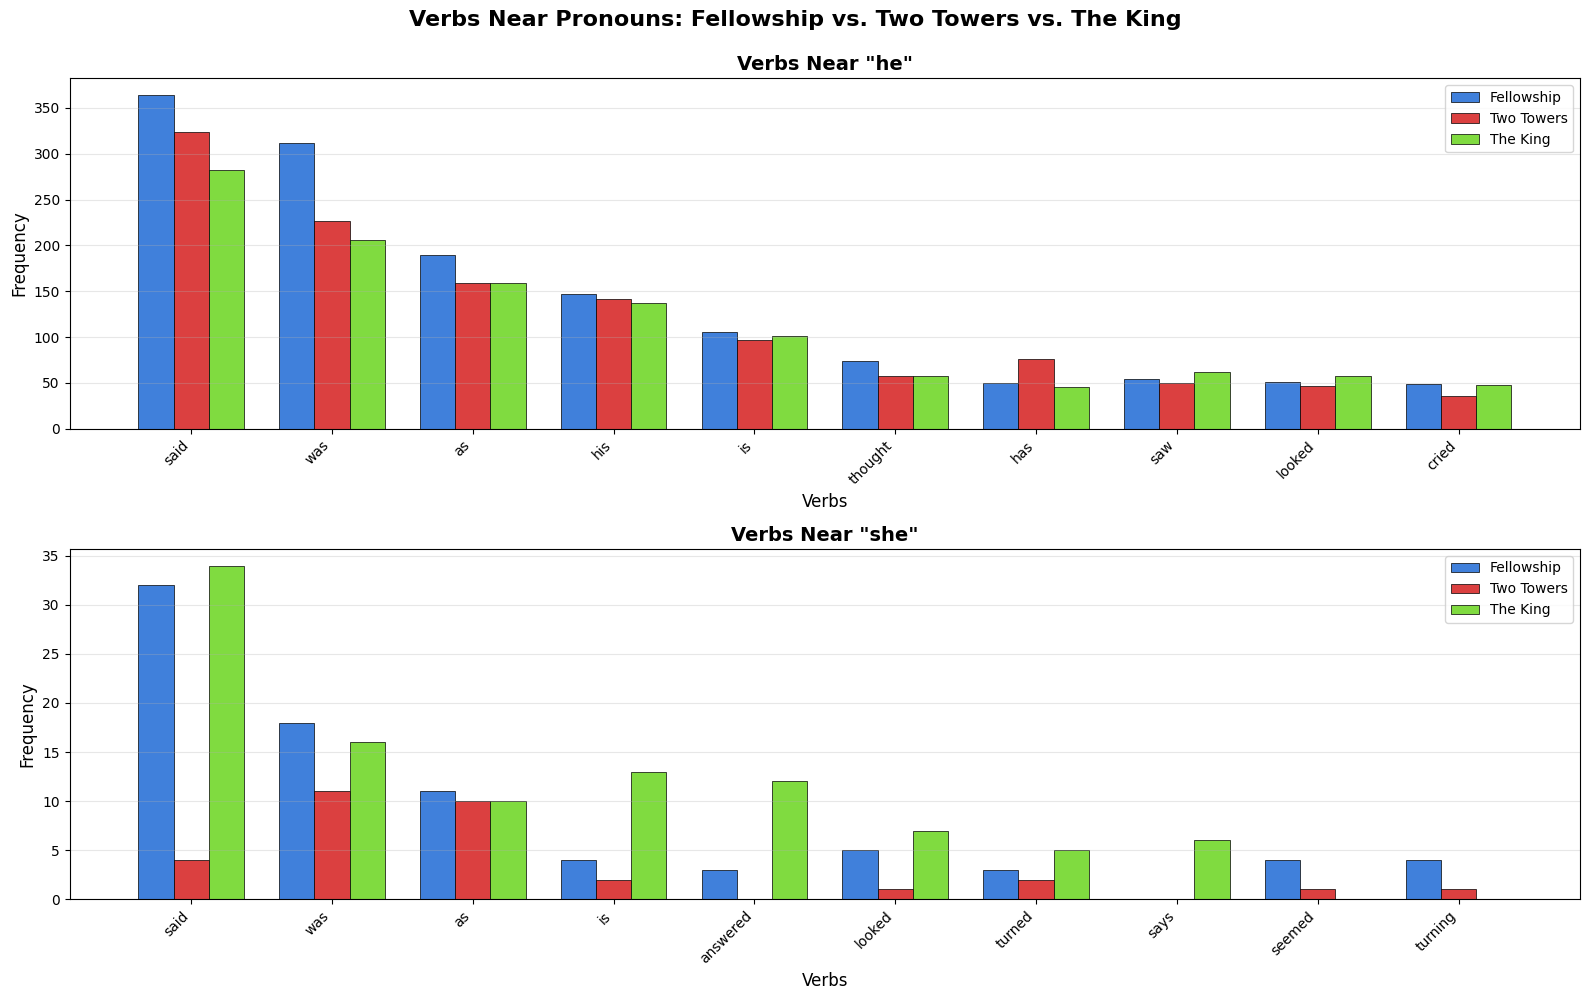

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Verbs Near Pronouns Analysis ---")

# 1. Get verb data for all three books
fellowship_verbs = verbs_near_pronouns(fellowship_words)
twotowers_verbs = verbs_near_pronouns(twotowers_words)
theking_verbs = verbs_near_pronouns(theking_words)

# 2. Get top 10 verbs for 'he' and 'she' combined across all books
all_he_verbs = {}
all_she_verbs = {}

for book_verbs in [fellowship_verbs, twotowers_verbs, theking_verbs]:
    for verb, count in book_verbs['he']:
        all_he_verbs[verb] = all_he_verbs.get(verb, 0) + count
    for verb, count in book_verbs['she']:
        all_she_verbs[verb] = all_she_verbs.get(verb, 0) + count

# Get top 10 verbs by total count
top_he_verbs = [v for v, _ in sorted(all_he_verbs.items(), key=lambda x: x[1], reverse=True)[:10]]
top_she_verbs = [v for v, _ in sorted(all_she_verbs.items(), key=lambda x: x[1], reverse=True)[:10]]

# Helper function to get count for a specific verb
def get_verb_count(verb_list, verb):
    for v, count in verb_list:
        if v == verb:
            return count
    return 0

# 3. Prepare data for plotting
he_fellowship = [get_verb_count(fellowship_verbs['he'], v) for v in top_he_verbs]
he_twotowers = [get_verb_count(twotowers_verbs['he'], v) for v in top_he_verbs]
he_theking = [get_verb_count(theking_verbs['he'], v) for v in top_he_verbs]

she_fellowship = [get_verb_count(fellowship_verbs['she'], v) for v in top_she_verbs]
she_twotowers = [get_verb_count(twotowers_verbs['she'], v) for v in top_she_verbs]
she_theking = [get_verb_count(theking_verbs['she'], v) for v in top_she_verbs]

# 4. Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Define colors
colors = ['#4080DB', '#DB4040', '#80DB40']
book_labels = ['Fellowship', 'Two Towers', 'The King']

# Plot for 'he'
x_he = np.arange(len(top_he_verbs))
width = 0.25

ax1.bar(x_he - width, he_fellowship, width, label='Fellowship', color=colors[0], edgecolor='black', linewidth=0.5)
ax1.bar(x_he, he_twotowers, width, label='Two Towers', color=colors[1], edgecolor='black', linewidth=0.5)
ax1.bar(x_he + width, he_theking, width, label='The King', color=colors[2], edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Verbs', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Verbs Near "he"', fontsize=14, fontweight='bold')
ax1.set_xticks(x_he)
ax1.set_xticklabels(top_he_verbs, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot for 'she'
x_she = np.arange(len(top_she_verbs))

ax2.bar(x_she - width, she_fellowship, width, label='Fellowship', color=colors[0], edgecolor='black', linewidth=0.5)
ax2.bar(x_she, she_twotowers, width, label='Two Towers', color=colors[1], edgecolor='black', linewidth=0.5)
ax2.bar(x_she + width, she_theking, width, label='The King', color=colors[2], edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Verbs', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Verbs Near "she"', fontsize=14, fontweight='bold')
ax2.set_xticks(x_she)
ax2.set_xticklabels(top_she_verbs, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Verbs Near Pronouns: Fellowship vs. Two Towers vs. The King', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Save the figure
plt.savefig('verbs_near_pronouns_chart.png', dpi=300, bbox_inches='tight')
print("Graph saved to 'verbs_near_pronouns_chart.png'")

plt.show()

In [9]:
# This helper function is from Notebook 1
def per_10k(count: int, total_words: int) -> float:
    """Normalize a raw count per 10,000 words for fair comparisons."""
    return (count / max(1, total_words)) * 10000.0

# --- Calculate Rates ---
# We use the counts from Cell 10 (f_c and k_c)
# and the total word counts from Cell 8 (nF and nR)

# 1. Fellowship Rates
f_he_him = f_c['he'] + f_c['him']
f_she_her = f_c['she'] + f_c['her']
f_he_him_rate = per_10k(f_he_him, nF)
f_she_her_rate = per_10k(f_she_her, nF)

# 2. TheKing Rates
r_he_him = k_c['he'] + k_c['him']
r_she_her = k_c['she'] + k_c['her']
r_he_him_rate = per_10k(r_he_him, nR)
r_she_her_rate = per_10k(r_she_her, nR)


print("--- Pronoun Rates (per 10,000 words) ---")
print(f"Fellowship - 'he/him':   {f_he_him_rate:5.2f}/10k")
print(f"Fellowship - 'she/her':  {f_she_her_rate:5.2f}/10k")
print(f"TheKing    - 'he/him':   {r_he_him_rate:5.2f}/10k")
print(f"TheKing    - 'she/her':  {r_she_her_rate:5.2f}/10k")

--- Pronoun Rates (per 10,000 words) ---
Fellowship - 'he/him':   203.86/10k
Fellowship - 'she/her':  16.98/10k
TheKing    - 'he/him':   227.96/10k
TheKing    - 'she/her':  26.47/10k


**Prompt:** How do these crude patterns line up with character agency and narrative voice? What errors do you notice, and how would POS (Part OF Speech) tagging improve this?

In [10]:
import pandas as pd
import altair as alt

# Create a DataFrame for the graph using the 4 rates we just calculated
data = [
    {'Book': 'Fellowship', 'Pronoun Group': 'He / Him', 'Rate': f_he_him_rate},
    {'Book': 'Fellowship', 'Pronoun Group': 'She / Her', 'Rate': f_she_her_rate},
    {'Book': 'TheKing', 'Pronoun Group': 'He / Him', 'Rate': r_he_him_rate},
    {'Book': 'TheKing', 'Pronoun Group': 'She / Her', 'Rate': r_she_her_rate}
]
chart_df = pd.DataFrame(data)

# Build a grouped bar chart
chart = alt.Chart(chart_df).mark_bar().encode(
    # On the x-axis, show the Pronoun Group
    x=alt.X('Pronoun Group', axis=None),
    # On the y-axis, show the Rate
    y=alt.Y('Rate', title='Rate (per 10k words)'),
    # Use color to distinguish the pronoun groups
    color=alt.Color('Pronoun Group'),
    # Create a separate column for each Book
    column=alt.Column('Book', header=alt.Header(titleOrient="bottom", labelOrient="bottom")),
    tooltip=['Book', 'Pronoun Group', 'Rate']
).properties(
    title='Character Focus (Gender): "He/Him" vs "She/Her"'
).interactive()

# Save the chart as a JSON file
chart.save('gender_comparison_chart.json')
print("Graph saved to 'gender_comparison_chart.json'")

# Display the chart
chart

Graph saved to 'gender_comparison_chart.json'


alt.Chart(...)